Основной задачей данного проекта является обработка первичных данных об учениках, которые сдали итоговый тест по математике. Цель проекта - выделить ключевые характеристики каждого студента для построения модели, которая может предсказать результат экзамена в зависимости от вводных данных.

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind


pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок
math = pd.read_csv('stud_math.csv')

math.info()
math.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null object
sex                    395 non-null object
age                    395 non-null int64
address                378 non-null object
famsize                368 non-null object
Pstatus                350 non-null object
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null object
famsup                 356 non-null object
paid                   355 non-null object
activities             381 non-null object
nursery                379 non-null object
studytime, granular    388 non-

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


Для начала заменим во всех столбцах значения NaN:

In [173]:
def change(i):
    math[i] = math[i].apply(lambda x: None if pd.isna(x) else x)


for cols in math.columns:
    change(cols)

In [174]:
# разобьем переменные на группы: бинарные, категориальные и числыовые
binary = []
for i in math.columns:
    if math.loc[:, i].nunique() == 2:
        binary.append(i)
numb = ['age', 'absences', 'score']
category = []
for i in math.columns:
    if i not in binary and i not in numb:
        category.append(i)

In [175]:
#создадим функцию для оценки качества данных категориальных и бинарных переменных:
def nom(column):
    display(pd.DataFrame(math.loc[:, column].value_counts()))
    print("Значений, встретившихся в столбце более 10 раз:",
          (math.loc[:, column].value_counts() > 10).sum())
    print("Уникальных значений:", math.loc[:, column].nunique())
    print("Нулевых значений:", math.loc[:, column].isna().sum())
    pd.DataFrame(math.loc[:, [column]].info())

In [176]:
# оценим бинарные переменные:
for c in binary:
    nom(c)

,school
GP,349
MS,46


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
school    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,sex
F,208
M,187


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
sex    395 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,address
U,295
R,83


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
address    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,famsize
GT3,261
LE3,107


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsize    368 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,Pstatus
T,314
A,36


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 45
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Pstatus    350 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,schoolsup
no,335
yes,51


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 9
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
schoolsup    386 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,famsup
yes,219
no,137


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 39
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famsup    356 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,paid
no,200
yes,155


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
paid    355 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,activities
yes,195
no,186


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
activities    381 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,nursery
yes,300
no,79


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 16
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
nursery    379 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,higher
yes,356
no,19


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 20
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
higher    375 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,internet
yes,305
no,56


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 34
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
internet    361 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,romantic
no,240
yes,124


Значений, встретившихся в столбце более 10 раз: 2
Уникальных значений: 2
Нулевых значений: 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
romantic    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


Большинство бинарных переменных имеют нулевые значения, 
которые в данный момент заполнить корректно не представляется возможным

In [177]:
# также рассмотрим категориальные переменные:
for n in category:
    nom(n)

,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 5
Нулевых значений: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Medu    392 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,Fedu
2.0,106
3.0,96
4.0,88
1.0,78
0.0,2
40.0,1


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 6
Нулевых значений: 24
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fedu    371 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5
Нулевых значений: 19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Mjob    376 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5
Нулевых значений: 36
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
Fjob    359 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,reason
course,137
home,104
reputation,103
other,34


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4
Нулевых значений: 17
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
reason    378 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,guardian
mother,250
father,86
other,28


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 3
Нулевых значений: 31
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
guardian    364 non-null object
dtypes: object(1)
memory usage: 3.2+ KB


,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


Значений, встретившихся в столбце более 10 раз: 3
Уникальных значений: 4
Нулевых значений: 28
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
traveltime    367 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,studytime
2.0,194
1.0,103
3.0,64
4.0,27


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4
Нулевых значений: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
studytime    388 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,failures
0.0,293
1.0,49
2.0,16
3.0,15


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4
Нулевых значений: 22
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
failures    373 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,"studytime, granular"
-6.0,194
-3.0,103
-9.0,64
-12.0,27


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 4
Нулевых значений: 7
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
studytime, granular    388 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,7
-1.0,1


Значений, встретившихся в столбце более 10 раз: 4
Уникальных значений: 6
Нулевых значений: 27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
famrel    368 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5
Нулевых значений: 11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
freetime    384 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5
Нулевых значений: 8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
goout    387 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


Значений, встретившихся в столбце более 10 раз: 5
Уникальных значений: 5
Нулевых значений: 15
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
health    380 non-null float64
dtypes: float64(1)
memory usage: 3.2 KB


1. В колонке Fedu есть ошибочное значение 40 (очевидно, что должно быть 4);
2. Загадка столбца studytime, granular разгадана - все значения данной переменной - это значения переменной studytime, умноженные на -3. Можно удалить этот столбец.
3. В столбце famrel ошибочное значение -1 (заменим на 1).
4. Во всех категориальных переменных также встречаются нулевые значения.

In [178]:
# заменим ошибочные значения в столбцах Fedu, famrel и удалим столбце studytime, granular:
math.loc[math.Fedu == 40, 'Fedu'] = float(4)
math.loc[math.famrel == -1, 'famrel'] = float(1)
math.drop(['studytime, granular'], inplace=True, axis=1)

count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

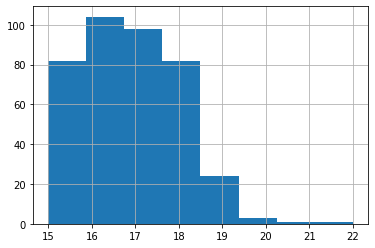

In [179]:
# рассмотрим числовые переменные, начнем с возраста:
math.age.hist(bins=8)
math.age.describe()

Нулевых и ошибочных значений нет, идем дальше.

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

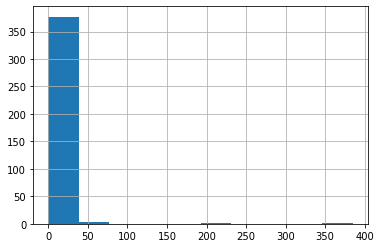

In [180]:
# рассмотрим переменную absences:
math.absences.hist()
math.absences.describe()

Очевидно, в данных присутствуют выбросы.
Также, необходимо заменить пропуски на медианное значение.

In [181]:
# Исправим ситуацию с помощью межквартильного интервала:
median = math.absences.median()
math.loc[math.absences.isna(), 'absences']==median
IQR = math.absences.quantile(0.75)-math.absences.quantile(0.25)
perc25 = math.absences.quantile(0.25)
perc75 = math.absences.quantile(0.75)
math = math.loc[math.absences.between(
    perc25 - 1.5*IQR, perc75 + 1.5*IQR)]  # очищаем от выбросов

count    361.000000
mean      51.994460
std       22.956117
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

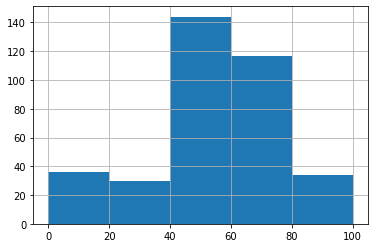

In [182]:
# Рассмотрим распределение итоговых оценок
math.score.hist(bins=5)
math.score.describe()
# Большая часть попадает в диапазон 40-80, выбросов нет.

In [183]:
# Посмотрим, сколько людей сдали тест на 0 баллов:
math.loc[math.score == 0, :].describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,36.000000,35.000000,33.000000,31.000000,36.000000,34.000000,33.000000,35.000000,35.000000,34.000000,36.0,36.0
mean,17.027778,2.371429,2.363636,1.516129,1.972222,0.794118,3.878788,3.114286,3.114286,3.647059,0.0,0.0
std,1.319873,1.031439,1.140674,0.724383,0.909823,0.977920,0.992395,0.900047,1.323352,1.323044,0.0,0.0
min,15.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,3.000000,3.000000,2.000000,3.000000,0.0,0.0
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.500000,4.000000,3.000000,3.000000,4.000000,0.0,0.0
75%,18.000000,3.000000,3.000000,2.000000,2.000000,1.000000,5.000000,4.000000,4.000000,5.000000,0.0,0.0
max,19.000000,4.000000,4.000000,3.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,0.0,0.0


Всего таких учеников 36. Полагаю, что эти ученики действителььно сдали свой тест на 0 баллов, т.к. данные ученики не пропускали занятий, а значит присутствовали при написании теста.

In [184]:
# Заменим неизвестные значения на медиану:
math.loc[math.score.isna(), 'score']=math.score.median()

In [185]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=math.loc[math.loc[:, column].isin(
                    math.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

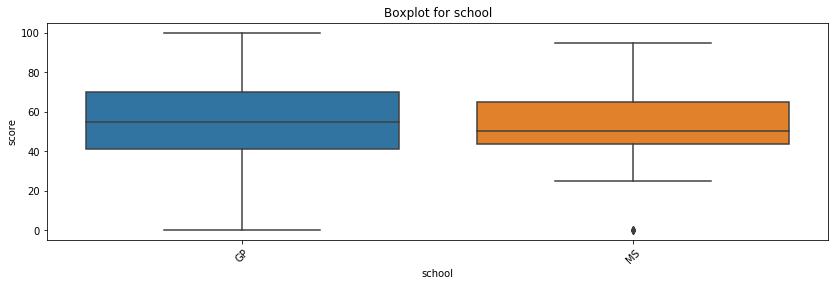

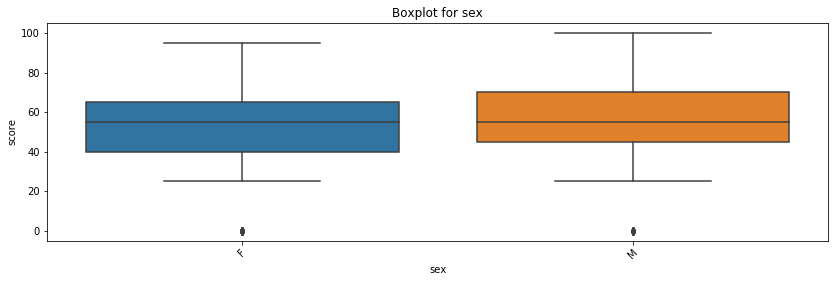

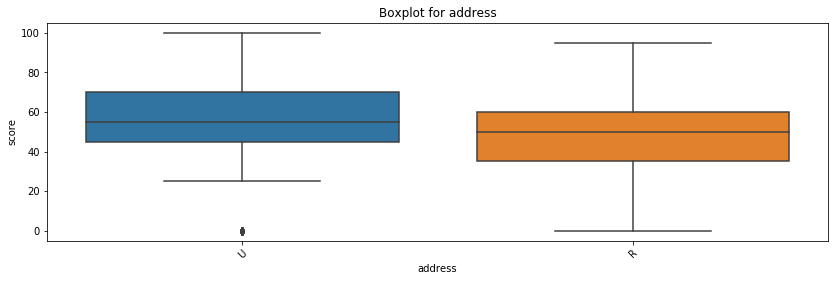

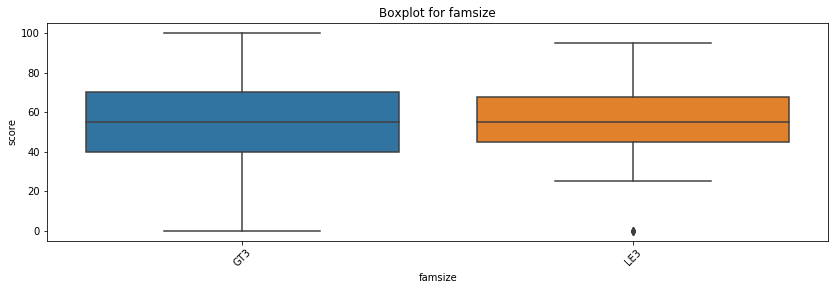

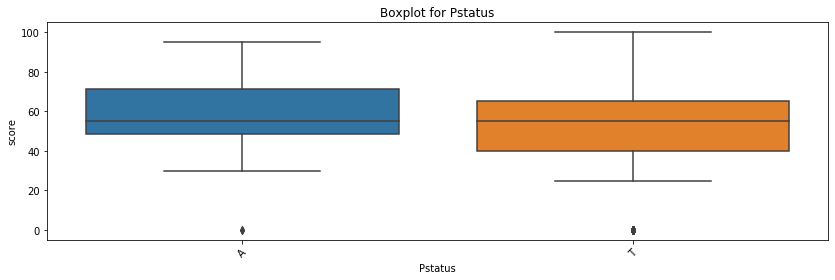

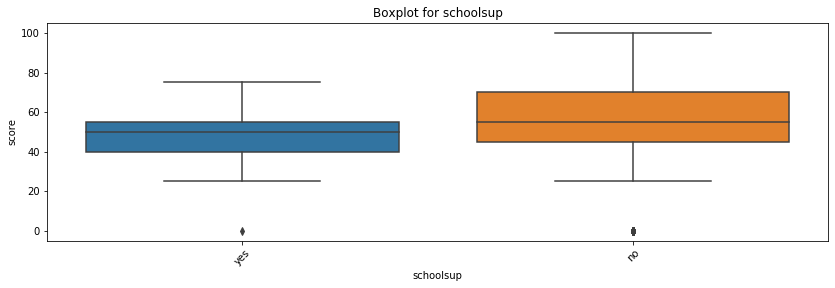

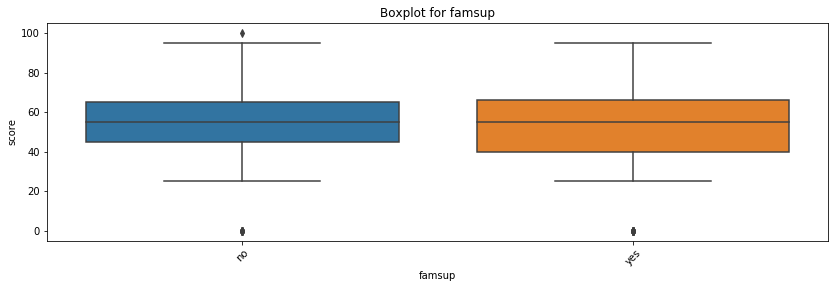

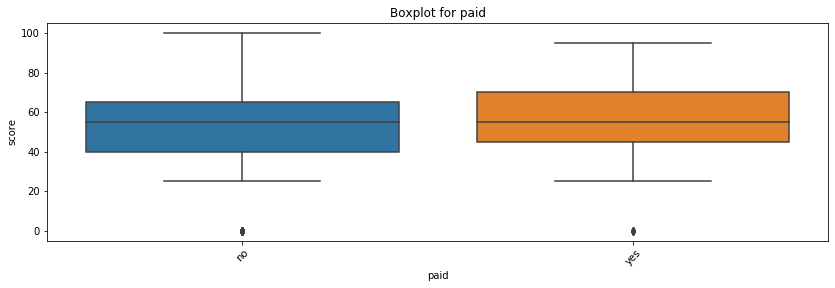

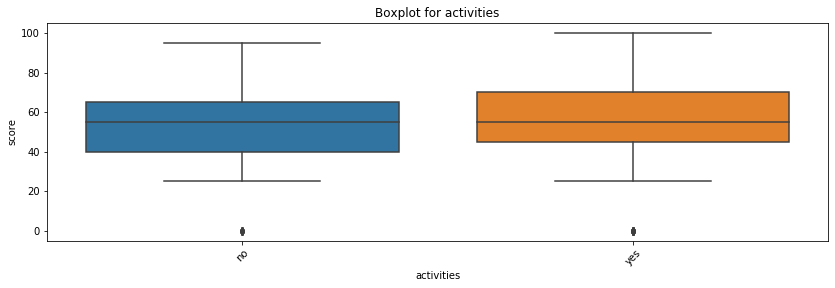

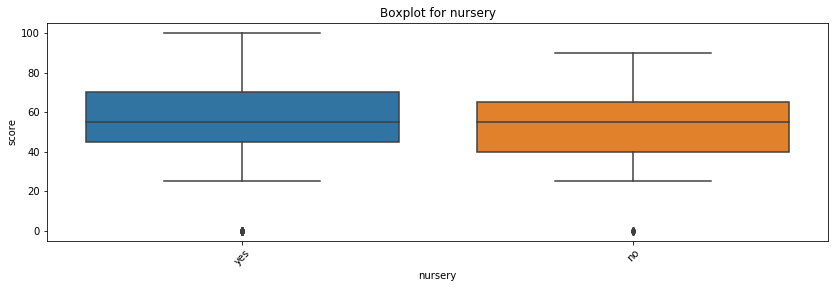

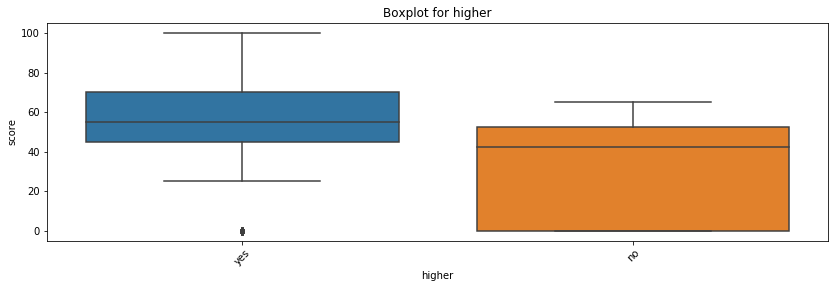

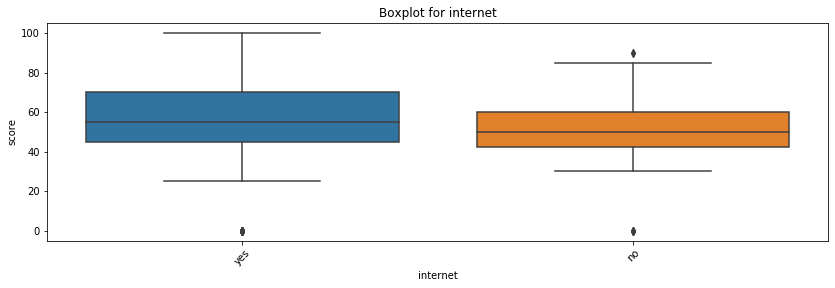

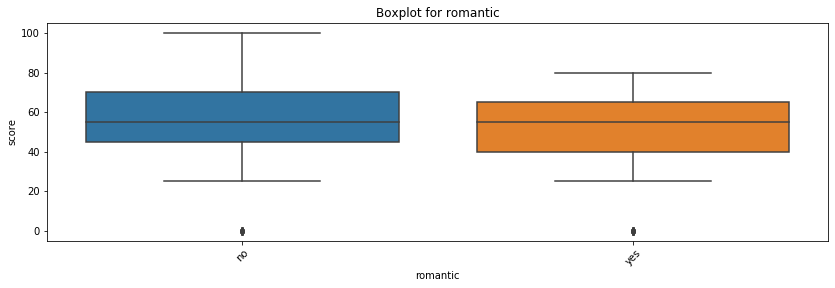

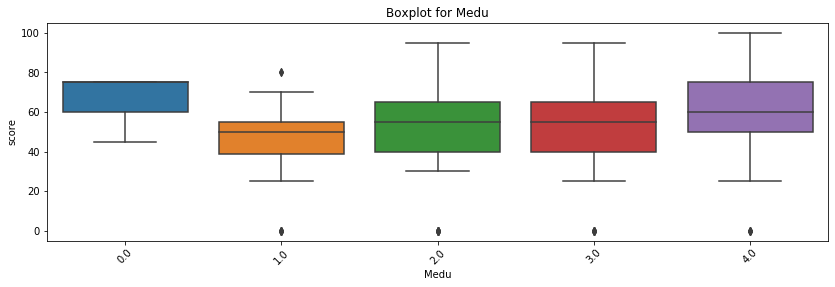

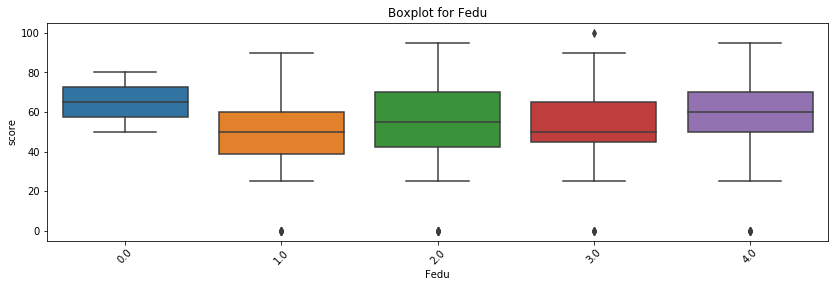

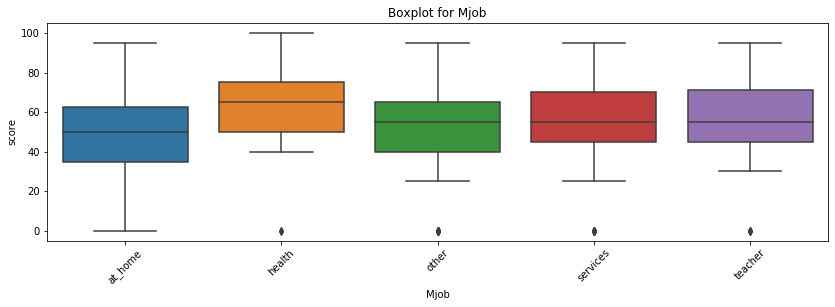

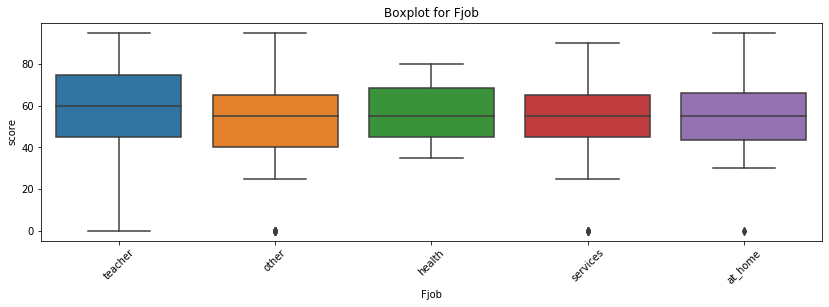

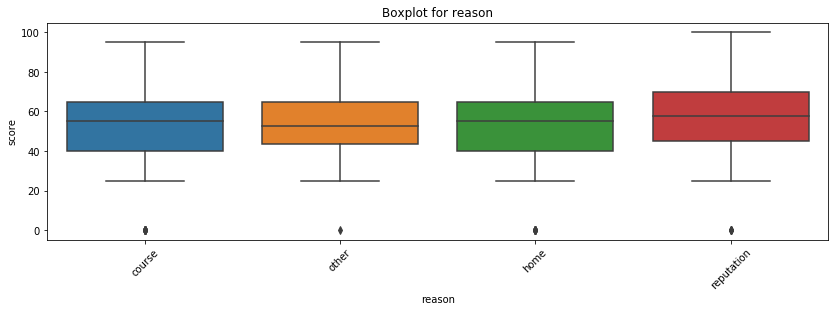

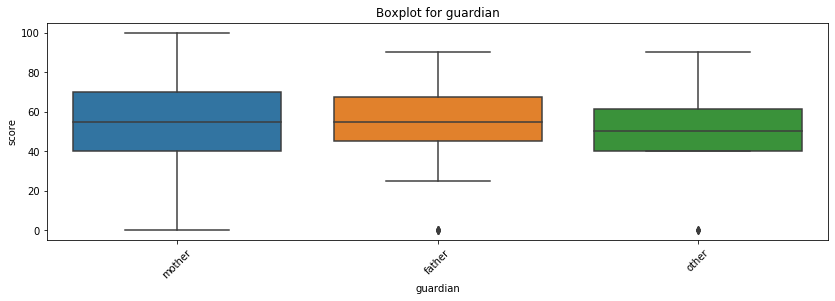

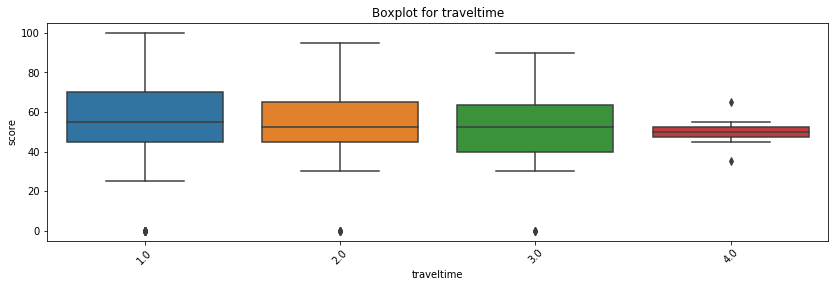

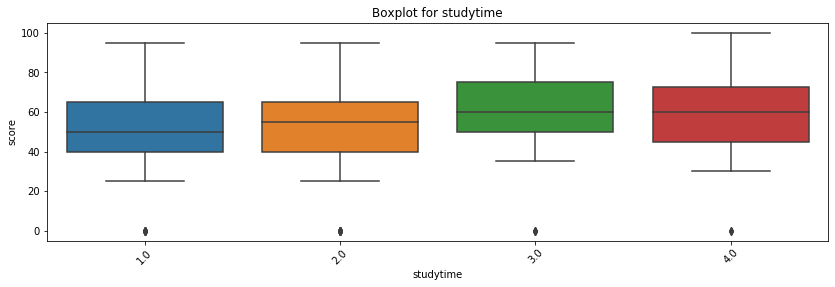

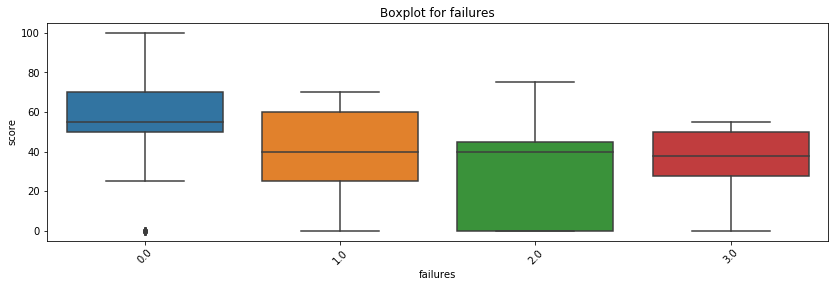

KeyError: 'studytime, granular'

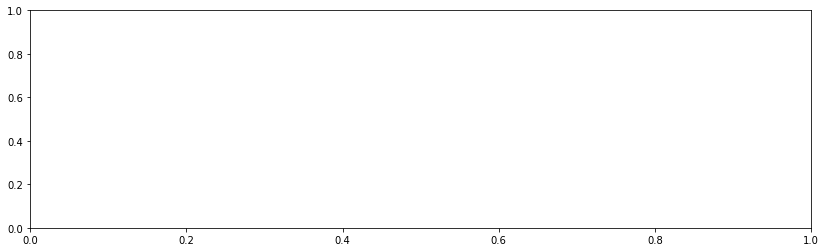

In [186]:
# Рассмотрим распределение оценок в зависимости от наших переменных на графиках:
for cols in list(binary+category):
    get_boxplot(cols)

In [187]:
# создадим функцию для оценки значимости бинарных и категориальных переменных:
def get_stat_dif(column):
    cols = math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(math.loc[math.loc[:, column] == comb[0], 'score'],
                     math.loc[math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [188]:
# удалим элемент из списка с категориальными переменными
category.remove('studytime, granular')

In [189]:
# проверим наши переменные:
for cols in list(binary+category):
    get_stat_dif(cols)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки paid
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки failures


In [ ]:
Интересно то, что результат теста влияют характеристики только одного родителя - матери. 
Предполагаю, что это обусловлено тем, что мать является в большинстве случаев основным опекуном.

Создадим дополнительные столбцы: образование и работа основного опекуна. 
В случаях, когда основным опекуном не является ни отец ни мать, возьмем значение по половому признаку.

In [190]:
math['main_job'] = math.apply(lambda x: x.Mjob if x.guardian == 'mother' else (
    x.Fjob if x.guardian == 'father' or x.sex == "M" else x.Mjob), axis=1)
math['main_ed'] = math.apply(lambda x: x.Medu if x.guardian == 'mother' else (
    x.Fedu if x.guardian == 'father' or x.sex == "M" else x.Medu), axis=1)

In [191]:
# Проверим нашу гипотезу о влиянии на результат основного опекуна
get_stat_dif('main_job')
get_stat_dif('main_ed')

Найдены статистически значимые различия для колонки main_ed


Теория подтвердилась только на уровне образования родителей.

In [192]:
# Проверим числовые переменные на значисть:
math[['age', 'absences', 'score']].corr()

,age,absences,score
age,1.000000,0.151493,-0.155300
absences,0.151493,1.000000,0.080948
score,-0.155300,0.080948,1.000000


Интересно, что с переменной age результат имеет отрицательную корреляцию.

Итог: мы получили список статистики значемых переменных для нашей будущей модели прогнозирования. Однако, большинство переменных содержат пропуски. Т.к. пропуски встречаются только в категориальных и бинарных переменных, то их заполнение на данном этапе может значительно наврдеить качеству данных. Заполнять пропущенные значения, на мой взгляд, необходимо непсредственно при построении модели.

In [195]:
# Создадим итоговую таблицу с необходимыми данными:
math_for_model=math.loc[:, ['sex', 'address', 'paid', 'higher', 'romantic', 'Mjob', 'failures', 'main_ed', 'age', 'absences', 'score']]
math_for_model.head()

,sex,address,paid,higher,romantic,Mjob,failures,main_ed,age,absences,score
0,F,U,no,yes,no,at_home,0.0,4.0,18,6.0,30.0
1,F,U,no,yes,no,at_home,0.0,1.0,17,4.0,30.0
2,F,U,None,yes,None,at_home,3.0,1.0,15,10.0,50.0
3,F,U,yes,yes,yes,health,0.0,4.0,15,2.0,75.0
4,F,U,yes,yes,no,other,0.0,3.0,16,4.0,50.0
